In [9]:
%matplotlib inline

# Imports
import gc
import matplotlib.pyplot as plt
import os
import statsmodels.stats.proportion
import sklearn.pipeline
import pandas
import numpy

# seaborn
import seaborn
seaborn.set()
seaborn.set_style("darkgrid")



In [7]:
# Get raw data
if os.path.exists("../data/output/raw_data_legacy.hdf.gz"):
    print("Loading raw_data from HDF5 cache")
    raw_data = pandas.read_hdf("../data/output/raw_data_legacy.hdf.gz", "root")
else :
    print("did not find raw_data cache")
    raw_data = get_raw_scdb_data("../data/input/SCDB_Legacy_01_justiceCentered_Citation.csv")
    raw_data.to_hdf("../data/output/raw_data_legacy.hdf.gz", "root", complevel=6, complib="zlib")

# Get feature data
if os.path.exists("../data/output/feature_data_legacy.hdf.gz"):
    print("Loading feature_df from HDF5 cache")
    feature_df = pandas.read_hdf("../data/output/feature_data_legacy.hdf.gz", "root")
else:
    # Process
    print("did not find feature_df cache")
    feature_df = preprocess_raw_data(raw_data, include_direction=True)
    
    # Write out feature datas
    feature_df.to_hdf("../data/output/feature_data_legacy.hdf.gz", "root", complevel=6, complib="zlib")

Loading raw_data from HDF5 cache
Loading feature_df from HDF5 cache


In [10]:
# Downsample to float
feature_df = feature_df.astype(numpy.float16)

In [11]:
# Remove term
nonterm_features = [f for f in feature_df.columns if not f.startswith("term_")]
original_feature_df = feature_df.copy()
feature_df = original_feature_df.loc[:, nonterm_features].copy()
gc.collect()

282

In [12]:
print(raw_data.shape)
print(feature_df.shape)
assert(raw_data.shape[0] == feature_df.shape[0])

(249793, 64)
(249793, 1501)


# Data exploration

## Let us first see how many decisions of the lower court were reversed

### Disposition key 
#### -1 : No opinion, 0: affirm, 1 : reverse

In [13]:
reverses = (raw_data.loc[:, "case_outcome_disposition"] > 0).astype(int).sum()
print(reverses)
affirmations = (raw_data.loc[:, "case_outcome_disposition"] == 0).astype(int).sum()
print(affirmations)
noOpinion = (raw_data.loc[:, "case_outcome_disposition"]  == -1).astype(int).sum()
print(noOpinion)


101239
116206
30079


In [14]:
total = len(raw_data)
print(" About " +  str(reverses*100/total) + "% cases were reversed by the supreme court")

 About 40.52915814294236% cases were reversed by the supreme court


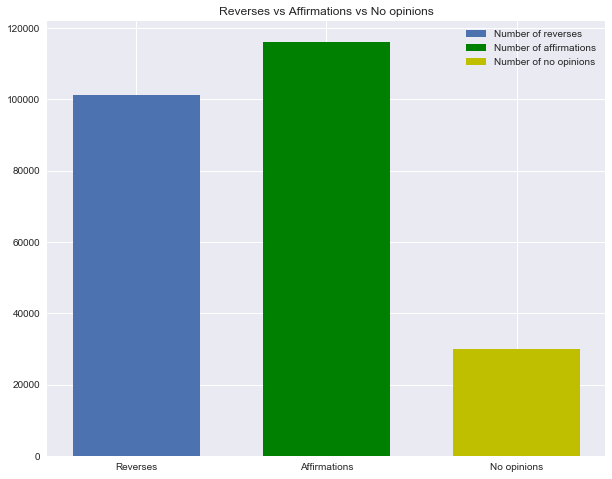

In [16]:
f = plt.figure(figsize=(10,8))
plt.bar([1],[reverses], label="Number of reverses", width=0.2)

plt.bar([1.3],[affirmations], label="Number of affirmations", color='g', width=0.2)
plt.bar([1.6],[noOpinion], label="Number of no opinions", color='y', width=0.2)

plt.legend()
plt.xticks([1,1.3, 1.6], ['Reverses', 'Affirmations', 'No opinions'])
plt.title('Reverses vs Affirmations vs No opinions')

plt.show()
outPDF = '../data/plots/figure_{}.pdf'.format('Reverses vs Affirmations')
f.savefig(outPDF, dpi=300)
outJPG = '../data/plots/figure_{}.jpg'.format('Reverses vs Affirmations')
f.savefig(outJPG, dpi=300)

## Let us now see how the delay between hearing the argument and making a decision affects the decision of the justices 

In [17]:
p = feature_df.loc[:,['decision_delay']]
q = raw_data.loc[:,['justice_outcome_disposition']]
check = pandas.concat([p, q], axis=1)
vote_1 = check[check['justice_outcome_disposition'] == 1]
vote_0 = check[check['justice_outcome_disposition'] == 0]
vote_minus_1 = check[check['justice_outcome_disposition'] == -1]
mean_delay_for_1 = vote_0[['decision_delay']].astype(numpy.float64).mean()
mean_delay_for_0 = vote_1[['decision_delay']].astype(numpy.float64).mean()
mean_delay_for_minus_1 = vote_minus_1[['decision_delay']].astype(numpy.float64).mean()
print("Mean delay between when the case was hered by the supreme court and when it made a decision : ")
print("Avg delay when the justices affirm the decision of the lower court : " + str(mean_delay_for_0))
print("Avg delay when the justices reverse the decision of the lower court : " + str(mean_delay_for_1))
print("Avg delay when the justices give no opinion on the case: " + str(mean_delay_for_minus_1))

Mean delay between when the case was hered by the supreme court and when it made a decision : 
Avg delay when the justices affirm the decision of the lower court : decision_delay    8.753632
dtype: float64
Avg delay when the justices reverse the decision of the lower court : decision_delay    7.484257
dtype: float64
Avg delay when the justices give no opinion on the case: decision_delay    4.518663
dtype: float64


As we see from the above analysis, decision delay is more for when the justices reverse the decision of the lower court

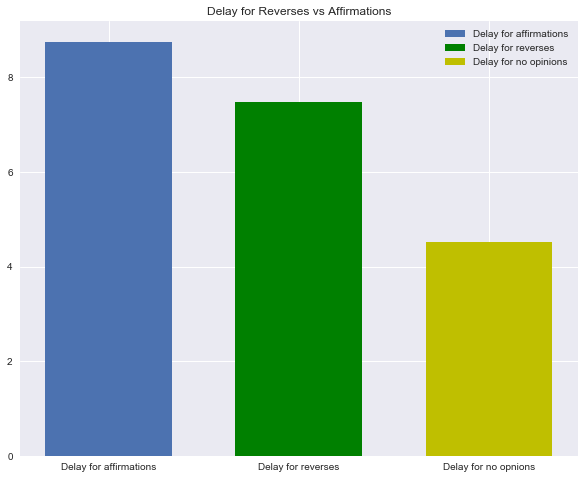

In [18]:
f = plt.figure(figsize=(10, 8))
plt.bar([1],[float(mean_delay_for_0)], label="Delay for affirmations", width=0.2)

plt.bar([1.3],[float(mean_delay_for_1)], label="Delay for reverses", color='g', width=0.2)
plt.bar([1.6],[float(mean_delay_for_minus_1)], label="Delay for no opinions", color='y', width=0.2)

plt.legend()
plt.xticks([1,1.3, 1.6], ['Delay for affirmations', 'Delay for reverses', 'Delay for no opnions'])
plt.title('Delay for Reverses vs Affirmations')

plt.show()
outPDF = '../data/plots/figure_{}.pdf'.format('Delay for Reverses vs Affirmations')
f.savefig(outPDF, dpi=300)
outJPG = '../data/plots/figure_{}.jpg'.format('Delay for Reverses vs Affirmations')
f.savefig(outJPG, dpi=300)

## Let us now see how the decisions vary depending upon if there was a disagreement on the case among the lower courts

In [19]:
p = raw_data.loc[:,['lcDisagreement']]
q = raw_data.loc[:,['case_outcome_disposition']]
check = pandas.concat([p, q], axis=1)
vote_1 = check[check['case_outcome_disposition'] == 1]
vote_0 = check[check['case_outcome_disposition'] == 0]
vote_minus_1 = check[check['case_outcome_disposition'] == -1]

In [20]:
disagreementAffirmed = vote_1['lcDisagreement'].sum()*100/len(vote_1)
disagreementReversed = vote_0['lcDisagreement'].sum()*100/len(vote_0)
diagreementNoOpinion = vote_minus_1['lcDisagreement'].sum()*100/len(vote_minus_1)
print(disagreementAffirmed)
print(disagreementReversed)
print(diagreementNoOpinion)

14.023251908849357
5.43345438273411
11.04425014129459


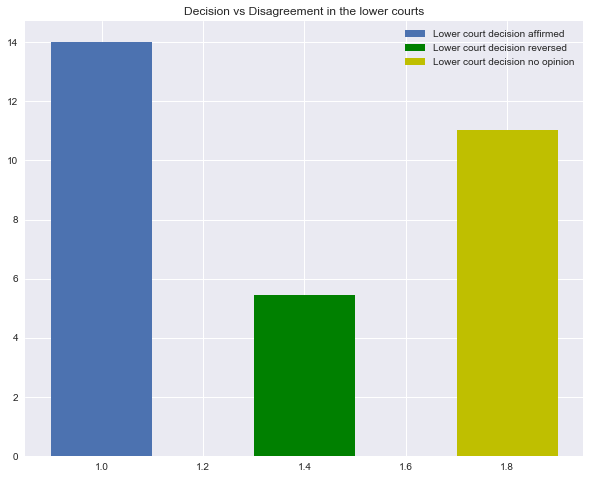

In [21]:
f = plt.figure(figsize=(10, 8))
plt.bar([1],[float(disagreementAffirmed)], label="Lower court decision affirmed", width=0.2)

plt.bar([1.4],[float(disagreementReversed)], label="Lower court decision reversed", color='g', width=0.2)
plt.bar([1.8],[float(diagreementNoOpinion)], label="Lower court decision no opinion", color='y', width=0.2)

plt.legend()
#plt.xticks([1,1.5, 1.8], ['Delay for affirmations', 'Delay for reverses', 'Lower court decision no opinion'])
plt.title('Decision vs Disagreement in the lower courts')

plt.show()
outPDF = '../data/plots/figure_{}.pdf'.format('Decision vs Disagreement in the lower courts')
f.savefig(outPDF, dpi=300)
outJPG = '../data/plots/figure_{}.jpg'.format('Decision vs Disagreement in the lower courts')
f.savefig(outJPG, dpi=300)

## Let us now explore how the decisions are effected by the petitioner group type

In [22]:
petGrp = "petitioner_group_"

In [23]:
petGrpList = []
for i in range(0,15):
    if i ==7 or i == 10:
        continue
    curr_group = petGrp + str(i)
    current_df = feature_df[feature_df[curr_group] == 1]
    temp = current_df.index.values
    raw_data.iloc[temp]
    temp2 = raw_data.iloc[temp]
    caseOutcomeDf = temp2[['case_outcome_disposition']]
    check = pandas.concat([current_df, caseOutcomeDf], axis=1)
    vote_1 = check[check['case_outcome_disposition'] == 1]
    vote_0 = check[check['case_outcome_disposition'] == 0]
    vote_minus_1 = check[check['case_outcome_disposition'] == -1]
    total = len(vote_1) + len(vote_0) + len(vote_minus_1)
    p = (len(vote_0)*100/total, len(vote_1)*100/total, len(vote_minus_1)*100/total)
    petGrpList.append(p)

In [24]:
arrAffirm = numpy.zeros(len(petGrpList))
arrReverse = numpy.zeros(len(petGrpList))
arrNoOpinion = numpy.zeros(len(petGrpList))
for i,item in enumerate(petGrpList):
    arrAffirm[i] = item[0]
    arrReverse[i] = item[1]
    arrNoOpinion[i] = item[2]

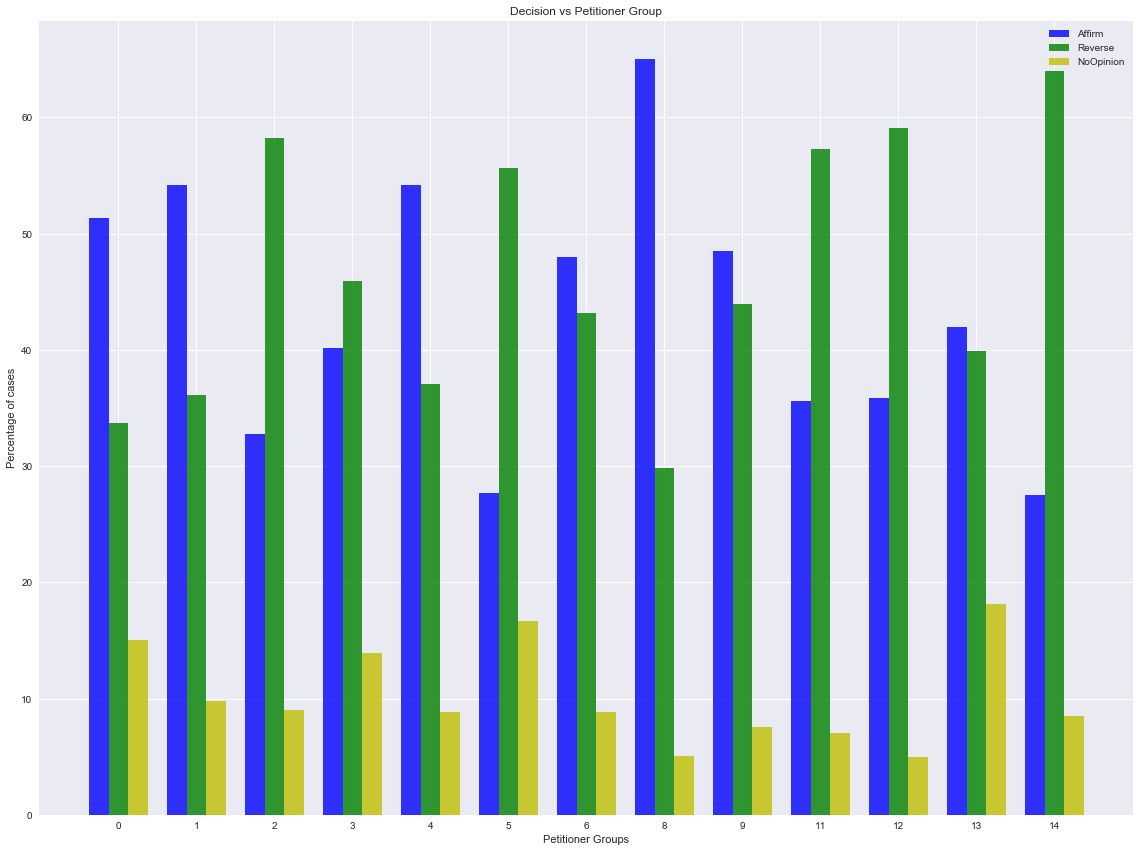

In [25]:

n_groups = len(petGrpList)

fig, ax = plt.subplots(figsize = (16,12))
index = numpy.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, arrAffirm, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Affirm')
 
rects2 = plt.bar(index + bar_width, arrReverse, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Reverse')

rects3 = plt.bar(index + bar_width*2, arrNoOpinion, bar_width,
                 alpha=opacity,
                 color='y',
                 label='NoOpinion')
 
plt.xlabel('Petitioner Groups')
plt.ylabel('Percentage of cases')
plt.title('Decision vs Petitioner Group')
plt.xticks(index + bar_width, ('0','1', '2', '3', '4','5','6','8','9','11','12','13','14'))
plt.legend()
 
plt.tight_layout()
plt.show()
outPDF = '../data/plots/figure_{}.pdf'.format('Decision vs Petitioner Group')
f.savefig(outPDF, dpi=300)
outJPG = '../data/plots/figure_{}.jpg'.format('Decision vs Petitioner Group')
f.savefig(outJPG, dpi=300)

## Let us now see how the decisions are effected by the group the respondent belongs to

In [26]:
resGrp = "respondent_group_"
resGrpList = []
for i in range(0,15):
    if i ==7 or i == 10:
        continue
    curr_group = resGrp + str(i)
    current_df = feature_df[feature_df[curr_group] == 1]
    temp = current_df.index.values
    raw_data.iloc[temp]
    temp2 = raw_data.iloc[temp]
    caseOutcomeDf = temp2[['case_outcome_disposition']]
    check = pandas.concat([current_df, caseOutcomeDf], axis=1)
    vote_1 = check[check['case_outcome_disposition'] == 1]
    vote_0 = check[check['case_outcome_disposition'] == 0]
    vote_minus_1 = check[check['case_outcome_disposition'] == -1]
    total = len(vote_1) + len(vote_0) + len(vote_minus_1)
    p = (len(vote_0)*100/total, len(vote_1)*100/total, len(vote_minus_1)*100/total)
    resGrpList.append(p)

arrAffirmRes = numpy.zeros(len(resGrpList))
arrReverseRes = numpy.zeros(len(resGrpList))
arrNoOpinionRes = numpy.zeros(len(resGrpList))
for i,item in enumerate(resGrpList):
    arrAffirmRes[i] = item[0]
    arrReverseRes[i] = item[1]
    arrNoOpinionRes[i] = item[2]

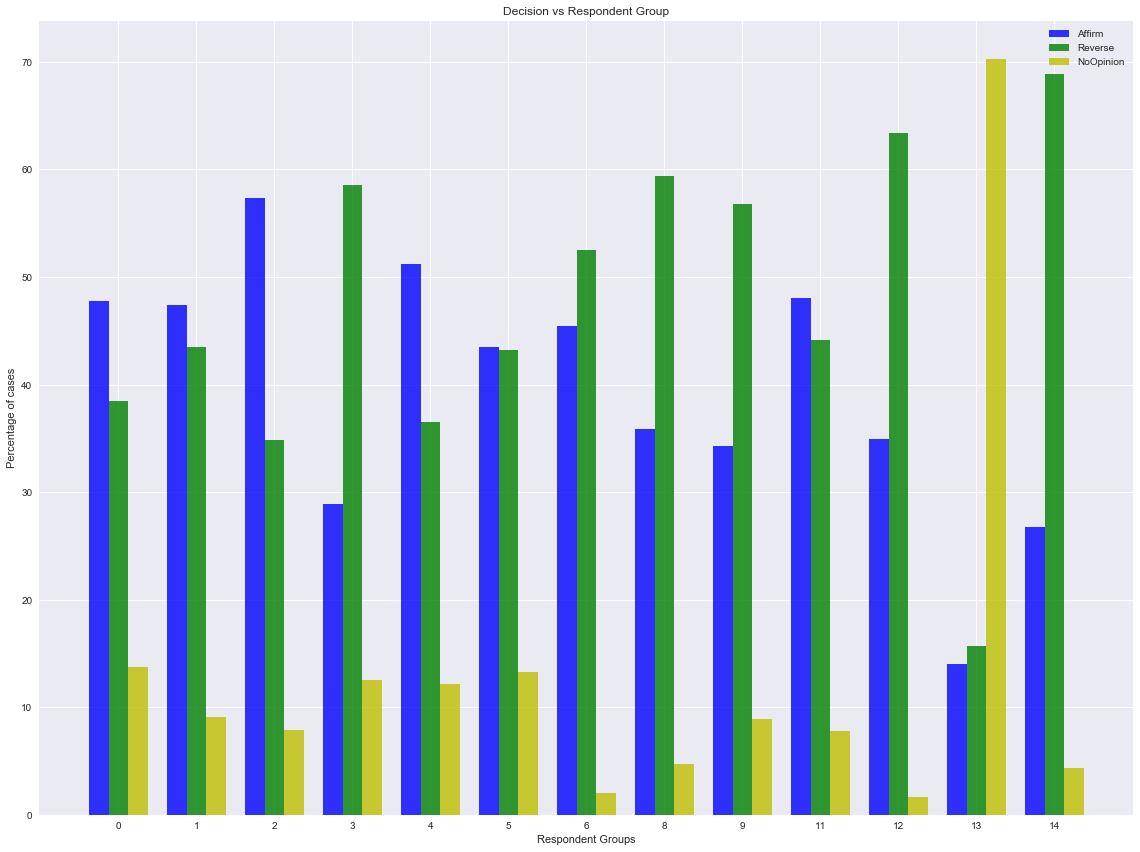

In [27]:

n_groups = len(resGrpList)
fig, ax = plt.subplots(figsize = (16,12))
index = numpy.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, arrAffirmRes, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Affirm')
 
rects2 = plt.bar(index + bar_width, arrReverseRes, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Reverse')

rects3 = plt.bar(index + bar_width*2, arrNoOpinionRes, bar_width,
                 alpha=opacity,
                 color='y',
                 label='NoOpinion')
 
plt.xlabel('Respondent Groups')
plt.ylabel('Percentage of cases')
plt.title('Decision vs Respondent Group')
plt.xticks(index + bar_width, ('0','1', '2', '3', '4','5','6','8','9','11','12','13','14'))
plt.legend()
 
plt.tight_layout()
plt.show()
outPDF = '../data/plots/figure_{}.pdf'.format('Decision vs Respondent Group')
f.savefig(outPDF, dpi=300)
outJPG = '../data/plots/figure_{}.jpg'.format('Decision vs Respondent Group')
f.savefig(outJPG, dpi=300)

## Let us now explore how the supreme court decisions vary across the issue areas

In [28]:
'''
1	Criminal Procedure
2	Civil Rights
3	First Amendment
4	Due Process
5	Privacy
6	Attorneys
7	Unions
8	Economic Activity
9	Judicial Power
10	Federalism
11	Interstate Relations
12	Federal Taxation
13	Miscellaneous
14	Private Action
'''

'\n1\tCriminal Procedure\n2\tCivil Rights\n3\tFirst Amendment\n4\tDue Process\n5\tPrivacy\n6\tAttorneys\n7\tUnions\n8\tEconomic Activity\n9\tJudicial Power\n10\tFederalism\n11\tInterstate Relations\n12\tFederal Taxation\n13\tMiscellaneous\n14\tPrivate Action\n'

In [29]:
issueArea = "issue_area_"
issueAreaList = []
for i in range(1,14):
    curr_group = issueArea + str(i)
    current_df = feature_df[feature_df[curr_group] == 1]
    temp = current_df.index.values
    raw_data.iloc[temp]
    temp2 = raw_data.iloc[temp]
    caseOutcomeDf = temp2[['case_outcome_disposition']]
    check = pandas.concat([current_df, caseOutcomeDf], axis=1)
    vote_1 = check[check['case_outcome_disposition'] == 1]
    vote_0 = check[check['case_outcome_disposition'] == 0]
    vote_minus_1 = check[check['case_outcome_disposition'] == -1]
    total = len(vote_1) + len(vote_0) + len(vote_minus_1)
    p = (len(vote_0)*100/total, len(vote_1)*100/total, len(vote_minus_1)*100/total)
    issueAreaList.append(p)

arrAffirmIssueArea = numpy.zeros(len(issueAreaList))
arrReverseIssueArea = numpy.zeros(len(issueAreaList))
arrNoOpinionIssueArea = numpy.zeros(len(issueAreaList))
for i,item in enumerate(issueAreaList):
    arrAffirmIssueArea[i] = item[0]
    arrReverseIssueArea[i] = item[1]
    arrNoOpinionIssueArea[i] = item[2]
#print(issueAreaList)

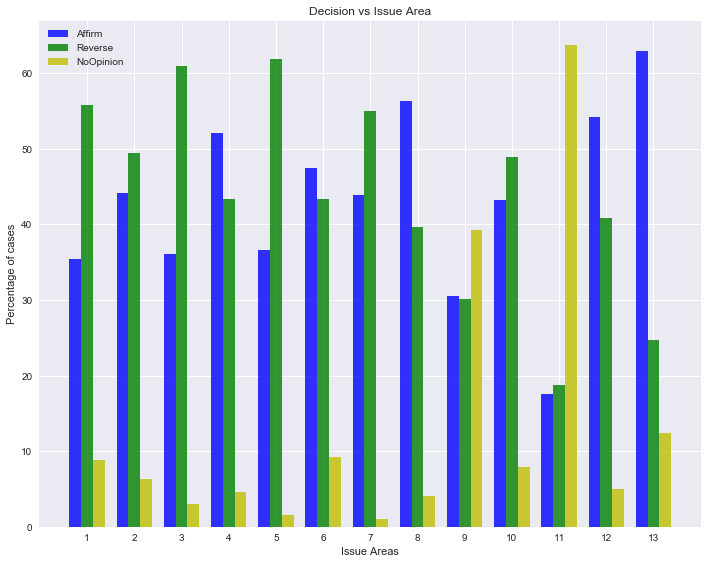

In [30]:

n_groups = len(issueAreaList)
fig, ax = plt.subplots(figsize = (10,8))
index = numpy.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, arrAffirmIssueArea, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Affirm')
 
rects2 = plt.bar(index + bar_width, arrReverseIssueArea, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Reverse')

rects3 = plt.bar(index + bar_width*2, arrNoOpinionIssueArea, bar_width,
                 alpha=opacity,
                 color='y',
                 label='NoOpinion')
 
plt.xlabel('Issue Areas')
plt.ylabel('Percentage of cases')
plt.title('Decision vs Issue Area')
plt.xticks(index + bar_width, ('1', '2', '3', '4','5','6','7','8','9','10','11','12','13'))
plt.legend()
 
plt.tight_layout()
plt.show()
outPDF = '../data/plots/figure_{}.pdf'.format('Decision vs Issue Area')
f.savefig(outPDF, dpi=300)
outJPG = '../data/plots/figure_{}.jpg'.format('Decision vs Issue Area')
f.savefig(outJPG, dpi=300)

## Let us see how the decisions vary across varies law types

In [31]:
'''
1	Constitution
2	Constitutional Amendment
3	Federal Statute
4	Court Rules
5	Other
6	Infrequently litigated statutes
8	State or local law or regulation
9	No Legal Provision
'''

'\n1\tConstitution\n2\tConstitutional Amendment\n3\tFederal Statute\n4\tCourt Rules\n5\tOther\n6\tInfrequently litigated statutes\n8\tState or local law or regulation\n9\tNo Legal Provision\n'

In [32]:
lawType = "law_type_"
lawTypeList = []
for i in range(1,10):
    if i==7:
        continue
    curr_group = lawType + str(i)
    current_df = feature_df[feature_df[curr_group] == 1]
    temp = current_df.index.values
    raw_data.iloc[temp]
    temp2 = raw_data.iloc[temp]
    caseOutcomeDf = temp2[['case_outcome_disposition']]
    check = pandas.concat([current_df, caseOutcomeDf], axis=1)
    vote_1 = check[check['case_outcome_disposition'] == 1]
    vote_0 = check[check['case_outcome_disposition'] == 0]
    vote_minus_1 = check[check['case_outcome_disposition'] == -1]
    total = len(vote_1) + len(vote_0) + len(vote_minus_1)
    p = (len(vote_0)*100/total, len(vote_1)*100/total, len(vote_minus_1)*100/total)
    lawTypeList.append(p)

arrAffirmLawType = numpy.zeros(len(lawTypeList))
arrReverseLawType = numpy.zeros(len(lawTypeList))
arrNoOpinionLawType = numpy.zeros(len(lawTypeList))
for i,item in enumerate(lawTypeList):
    arrAffirmLawType[i] = item[0]
    arrReverseLawType[i] = item[1]
    arrNoOpinionLawType[i] = item[2]
#print(lawTypeList)

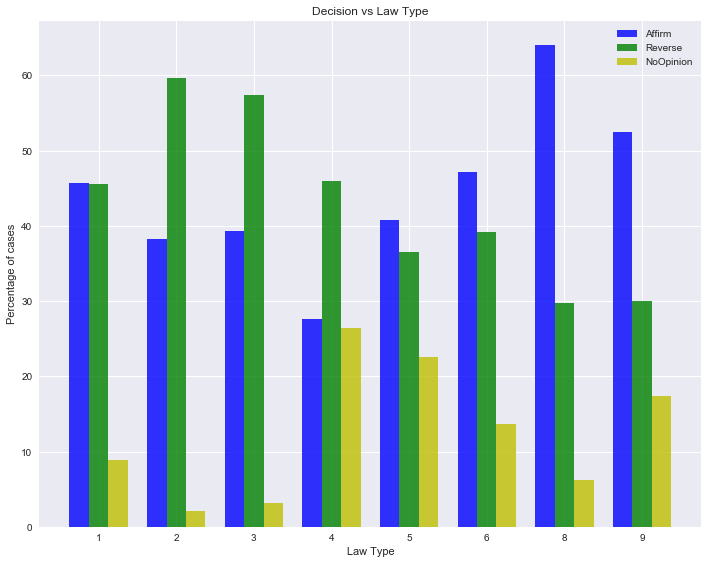

In [33]:

n_groups = len(lawTypeList)
fig, ax = plt.subplots(figsize = (10,8))
index = numpy.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, arrAffirmLawType, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Affirm')
 
rects2 = plt.bar(index + bar_width, arrReverseLawType, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Reverse')

rects3 = plt.bar(index + bar_width*2, arrNoOpinionLawType, bar_width,
                 alpha=opacity,
                 color='y',
                 label='NoOpinion')
 
plt.xlabel('Law Type')
plt.ylabel('Percentage of cases')
plt.title('Decision vs Law Type')
plt.xticks(index + bar_width, ('1', '2', '3', '4','5','6','8','9'))
plt.legend()
 
plt.tight_layout()
plt.show()
outPDF = '../data/plots/figure_{}.pdf'.format('Decision vs Law Type')
plt.savefig(outPDF, dpi=300)
outJPG = '../data/plots/figure_{}.jpg'.format('Decision vs Law Type')
plt.savefig(outJPG, dpi=300)

## Now let us see how the decisions have changed across different natural courts

In [37]:
labels = feature_df.columns.values
labels_list = labels.tolist()
natural_court_list = []
for item in labels_list:
    if item.startswith('natural_court_'):
        #print(item)
        natural_court_list.append(item)

In [38]:
if 'natural_court_raw' in natural_court_list: 
    natural_court_list.remove('natural_court_raw')
if 'natural_court_-1' in natural_court_list:
    natural_court_list.remove('natural_court_-1')
#natural_court_list
natural_court_list_numbers = []
for item in natural_court_list:
    natural_court_list_numbers.append(item[14:len(item)])
#natural_court_list_numbers

In [39]:
naturalCourtList = []
for item in natural_court_list:
    #curr_group = lawType + str(i)
    current_df = feature_df[feature_df[item] == 1]
    temp = current_df.index.values
    raw_data.iloc[temp]
    temp2 = raw_data.iloc[temp]
    caseOutcomeDf = temp2[['case_outcome_disposition']]
    check = pandas.concat([current_df, caseOutcomeDf], axis=1)
    vote_1 = check[check['case_outcome_disposition'] == 1]
    vote_0 = check[check['case_outcome_disposition'] == 0]
    vote_minus_1 = check[check['case_outcome_disposition'] == -1]
    total = len(vote_1) + len(vote_0) + len(vote_minus_1)
    p = (len(vote_0)*100/total, len(vote_1)*100/total, len(vote_minus_1)*100/total)
    naturalCourtList.append(p)

arrAffirmNatCourt = numpy.zeros(len(naturalCourtList))
arrReverseNatCourt = numpy.zeros(len(naturalCourtList))
arrNoOpinionNatCourt = numpy.zeros(len(naturalCourtList))
for i,item in enumerate(naturalCourtList):
    arrAffirmNatCourt[i] = item[0]
    arrReverseNatCourt[i] = item[1]
    arrNoOpinionNatCourt[i] = item[2]
#print(naturalCourtList)

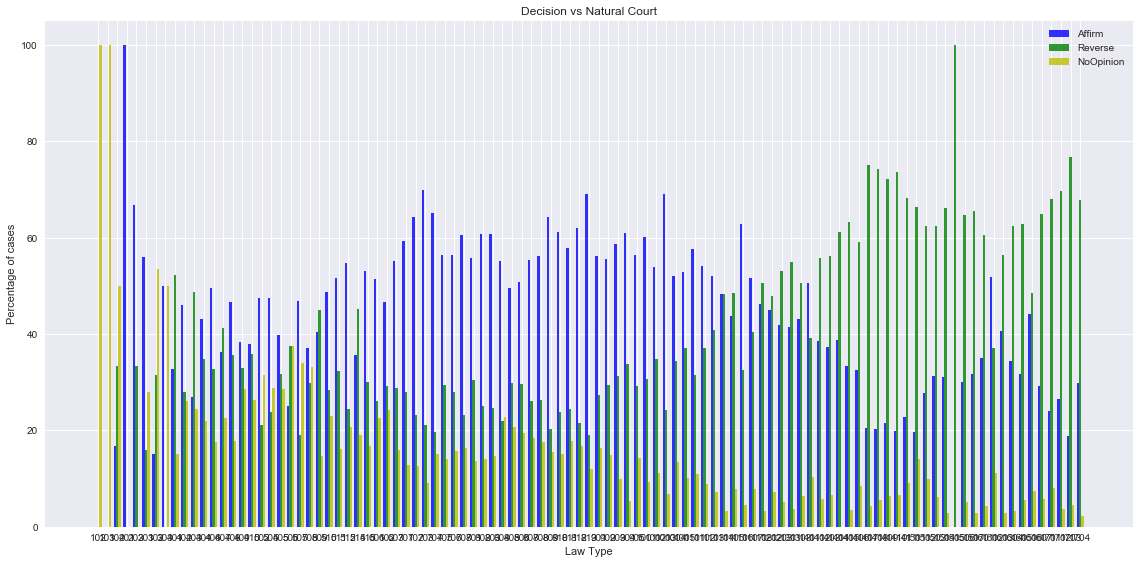

In [40]:

n_groups = len(naturalCourtList)
fig, ax = plt.subplots(figsize = (16,8))
index = numpy.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, arrAffirmNatCourt, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Affirm')
 
rects2 = plt.bar(index + bar_width, arrReverseNatCourt, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Reverse')

rects3 = plt.bar(index + bar_width*2, arrNoOpinionNatCourt, bar_width,
                 alpha=opacity,
                 color='y',
                 label='NoOpinion')
 
plt.xlabel('Law Type')
plt.ylabel('Percentage of cases')
plt.title('Decision vs Natural Court')
plt.xticks(index + bar_width, natural_court_list_numbers)
plt.legend()
 
plt.tight_layout()
plt.show()
outPDF = '../data/plots/figure_{}.pdf'.format('Decision vs Natural Court')
f.savefig(outPDF, dpi=300)
outJPG = '../data/plots/figure_{}.jpg'.format('Decision vs Natural Court')
f.savefig(outJPG, dpi=300)

## Let us now see how the decision is affected by the reason the supreme court decided to hear the case

In [41]:
'''
1	case did not arise on cert or cert not granted
2	federal court conflict
3	federal court conflict and to resolve important or significant question
4	putative conflict
5	conflict between federal court and state court
6	state court conflict
7	federal court confusion or uncertainty
8	state court confusion or uncertainty
9	federal court and state court confusion or uncertainty
10	to resolve important or significant question
11	to resolve question presented
12	no reason given
13	other reason
'''

'\n1\tcase did not arise on cert or cert not granted\n2\tfederal court conflict\n3\tfederal court conflict and to resolve important or significant question\n4\tputative conflict\n5\tconflict between federal court and state court\n6\tstate court conflict\n7\tfederal court confusion or uncertainty\n8\tstate court confusion or uncertainty\n9\tfederal court and state court confusion or uncertainty\n10\tto resolve important or significant question\n11\tto resolve question presented\n12\tno reason given\n13\tother reason\n'

In [42]:
labels = feature_df.columns.values
labels_list = labels.tolist()
reason_cert_list = []
for item in labels_list:
    if item.startswith('cert_reason_'):
        #print(item)
        reason_cert_list.append(item)

In [43]:
if 'cert_reason_-1' in reason_cert_list:
    reason_cert_list.remove('cert_reason_-1')
#reason_cert_list
reason_cert_list_numbers = []
for item in reason_cert_list:
    reason_cert_list_numbers.append(item[12:len(item)])
#reason_cert_list_numbers

In [44]:
reasonCertList = []
for item in reason_cert_list:
    #curr_group = lawType + str(i)
    current_df = feature_df[feature_df[item] == 1]
    temp = current_df.index.values
    raw_data.iloc[temp]
    temp2 = raw_data.iloc[temp]
    caseOutcomeDf = temp2[['case_outcome_disposition']]
    check = pandas.concat([current_df, caseOutcomeDf], axis=1)
    vote_1 = check[check['case_outcome_disposition'] == 1]
    vote_0 = check[check['case_outcome_disposition'] == 0]
    vote_minus_1 = check[check['case_outcome_disposition'] == -1]
    total = len(vote_1) + len(vote_0) + len(vote_minus_1)
    p = (len(vote_0)*100/total, len(vote_1)*100/total, len(vote_minus_1)*100/total)
    reasonCertList.append(p)

arrAffirmReasonCert = numpy.zeros(len(reasonCertList))
arrReverseReasonCert = numpy.zeros(len(reasonCertList))
arrNoOpinionReasonCert = numpy.zeros(len(reasonCertList))
for i,item in enumerate(reasonCertList):
    arrAffirmReasonCert[i] = item[0]
    arrReverseReasonCert[i] = item[1]
    arrNoOpinionReasonCert[i] = item[2]
#print(reasonCertList)

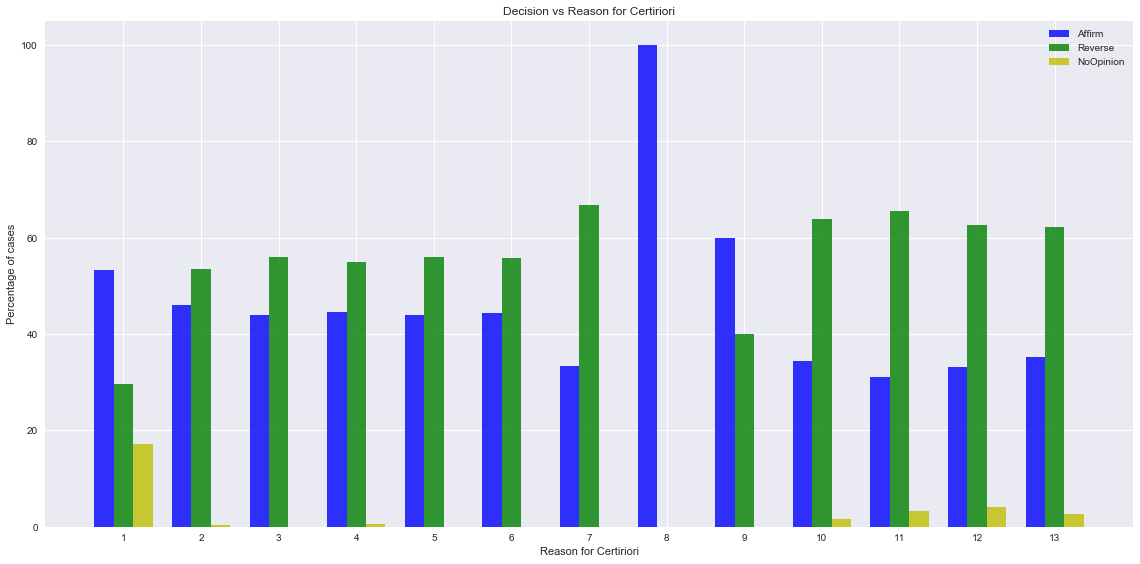

In [45]:

n_groups = len(reasonCertList)
fig, ax = plt.subplots(figsize = (16,8))
index = numpy.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, arrAffirmReasonCert, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Affirm')
 
rects2 = plt.bar(index + bar_width, arrReverseReasonCert, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Reverse')

rects3 = plt.bar(index + bar_width*2, arrNoOpinionReasonCert, bar_width,
                 alpha=opacity,
                 color='y',
                 label='NoOpinion')
 
plt.xlabel('Reason for Certiriori')
plt.ylabel('Percentage of cases')
plt.title('Decision vs Reason for Certiriori')
plt.xticks(index + bar_width, reason_cert_list_numbers)
plt.legend()
 
plt.tight_layout()
plt.show()
outPDF = '../data/plots/figure_{}.pdf'.format('Decision vs Reason for Certiriori')
f.savefig(outPDF, dpi=300)
outJPG = '../data/plots/figure_{}.jpg'.format('Decision vs Reason for Certiriori')
f.savefig(outJPG, dpi=300)
#plt.savefig(pa)